<a href="https://colab.research.google.com/github/XimenaCantera/MSMGC_ActividadIntegradora/blob/main/RobotCajas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Semilla para la generación de números aleatorios
random.seed(67890)
np.random.seed(67890)

# Constantes
WAREHOUSE_SIZE = 20
NUM_BOXES = 200
NUM_ROBOTS = 5
MAX_BOX_STACK = 3
TARGET_STACK_HEIGHT = 5

# Inicialización del almacén (0: vacío, -1: pared, 1-5: número de cajas en la pila)
warehouse = np.zeros((WAREHOUSE_SIZE, WAREHOUSE_SIZE), dtype=int)


In [2]:
def place_initial_boxes(warehouse, num_boxes, max_box_stack):
    remaining_boxes = num_boxes
    while remaining_boxes > 0:
        stack_height = min(random.randint(1, max_box_stack), remaining_boxes)
        x, y = random.randint(0, WAREHOUSE_SIZE-1), random.randint(0, WAREHOUSE_SIZE-1)
        if warehouse[x, y] == 0:
            warehouse[x, y] = stack_height
            remaining_boxes -= stack_height

place_initial_boxes(warehouse, NUM_BOXES, MAX_BOX_STACK)
print(warehouse)


[[0 3 2 0 0 0 0 0 0 0 1 0 2 2 0 0 3 0 0 0]
 [0 3 0 2 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 3 0 0 0 2 0 0 0 3 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 2 0 2 0 0 0 1 1]
 [0 0 0 0 0 0 1 0 1 2 0 0 0 1 0 0 0 0 3 0]
 [1 0 0 0 0 0 0 0 0 2 1 0 0 0 1 2 2 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 3 2 0 0 0 0 3 0 0]
 [0 1 0 0 3 0 0 0 0 0 0 0 0 0 0 3 3 0 0 3]
 [3 0 0 3 0 0 0 3 1 0 0 0 0 0 0 0 3 0 0 3]
 [2 3 0 0 0 0 2 0 0 1 0 0 0 0 0 0 1 0 2 0]
 [0 1 0 0 0 0 0 0 2 1 1 0 0 2 0 0 0 0 0 0]
 [0 3 0 0 0 2 0 0 0 0 0 3 0 0 0 3 0 0 0 0]
 [0 0 2 0 0 0 0 0 1 0 0 3 1 0 0 0 0 0 1 0]
 [0 2 0 0 0 0 3 3 0 0 0 0 0 3 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 2 1 0 0 1 1 2 0 1 0 0]
 [0 0 1 0 0 0 0 1 0 0 2 0 0 0 0 2 0 0 2 0]
 [0 2 0 0 0 1 0 3 0 0 3 0 0 1 1 0 0 0 0 3]
 [0 0 0 0 0 0 0 2 1 1 0 0 0 0 0 0 0 0 1 2]
 [0 2 0 0 0 0 3 1 0 0 0 0 0 0 0 1 0 0 3 0]
 [0 0 0 1 0 0 2 0 3 0 2 0 0 0 3 1 0 0 0 0]]


In [3]:
robots = []

def place_robots(warehouse, num_robots):
    while len(robots) < num_robots:
        x, y = random.randint(0, WAREHOUSE_SIZE-1), random.randint(0, WAREHOUSE_SIZE-1)
        if warehouse[x, y] == 0 and (x, y) not in robots:
            robots.append((x, y))

place_robots(warehouse, NUM_ROBOTS)
print(robots)


[(9, 2), (6, 19), (2, 3), (14, 4), (16, 9)]


In [4]:
def move_robot(robot, direction):
    x, y = robot
    if direction == 'up' and x > 0:
        x -= 1
    elif direction == 'down' and x < WAREHOUSE_SIZE - 1:
        x += 1
    elif direction == 'left' and y > 0:
        y -= 1
    elif direction == 'right' and y < WAREHOUSE_SIZE - 1:
        y += 1
    return (x, y)


In [5]:
def get_adjacent_cells(robot):
    x, y = robot
    cells = {
        'up': (x-1, y) if x > 0 else None,
        'down': (x+1, y) if x < WAREHOUSE_SIZE - 1 else None,
        'left': (x, y-1) if y > 0 else None,
        'right': (x, y+1) if y < WAREHOUSE_SIZE - 1 else None
    }
    return cells

def sense_environment(robot, warehouse):
    cells = get_adjacent_cells(robot)
    sensed = {}
    for direction, cell in cells.items():
        if cell is None:
            sensed[direction] = 'wall'
        else:
            x, y = cell
            if warehouse[x, y] == -1:
                sensed[direction] = 'wall'
            elif warehouse[x, y] == 0:
                sensed[direction] = 'empty'
            elif 1 <= warehouse[x, y] <= 5:
                sensed[direction] = f'boxes_{warehouse[x, y]}'
            elif cell in robots:
                sensed[direction] = 'robot'
    return sensed


In [6]:
def pick_up_box(robot, warehouse):
    x, y = robot
    if warehouse[x, y] > 0:
        warehouse[x, y] -= 1
        return True
    return False

def drop_box(robot, warehouse):
    x, y = robot
    if warehouse[x, y] < TARGET_STACK_HEIGHT:
        warehouse[x, y] += 1
        return True
    return False


In [7]:
def robot_strategy(robot, warehouse):
    if random.random() > 0.5:
        directions = ['up', 'down', 'left', 'right']
        random.shuffle(directions)
        for direction in directions:
            new_pos = move_robot(robot, direction)
            if sense_environment(new_pos, warehouse)[direction] == 'empty':
                return new_pos
    else:
        x, y = robot
        if warehouse[x, y] < TARGET_STACK_HEIGHT:
            return robot
    return robot


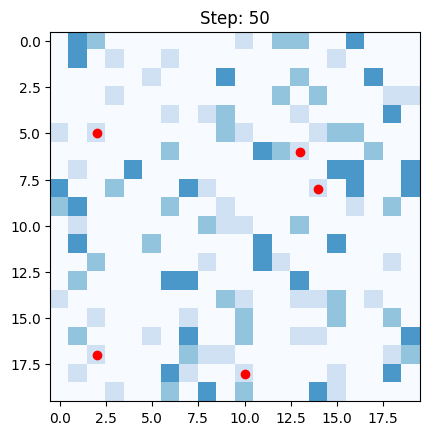

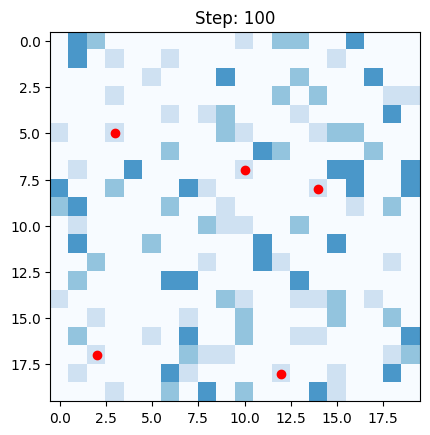

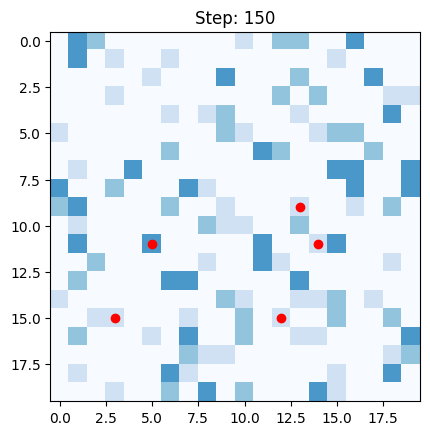

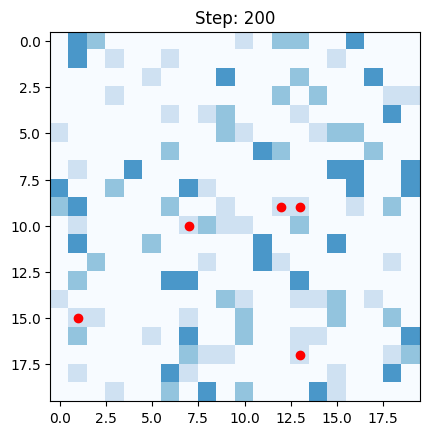

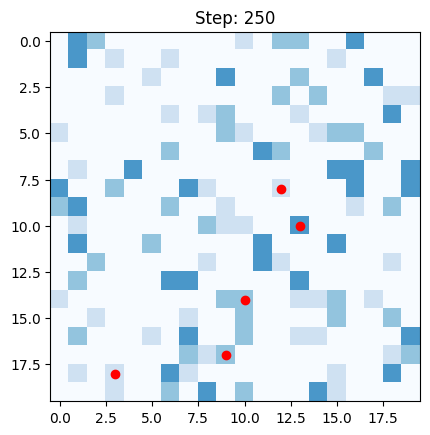

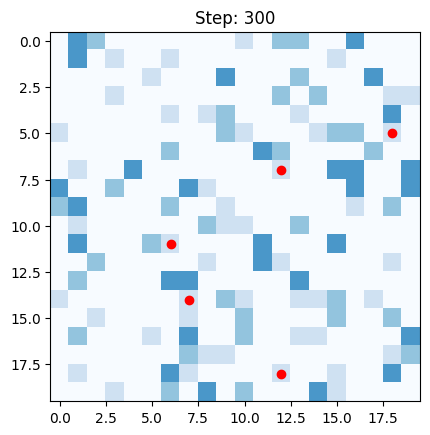

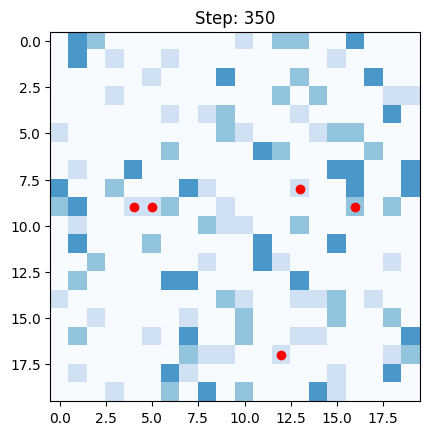

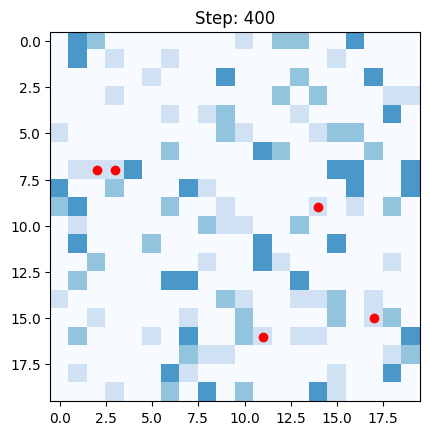

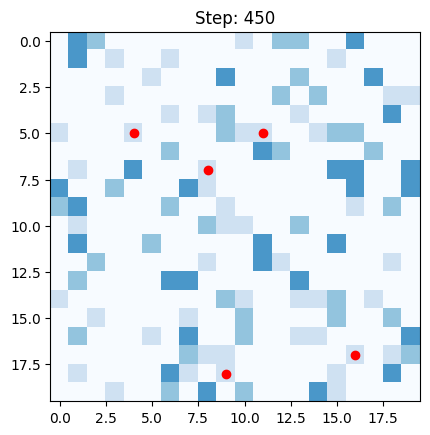

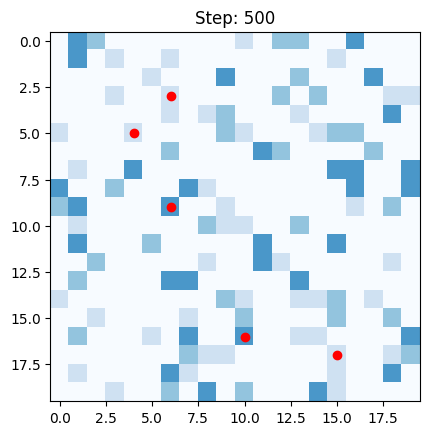

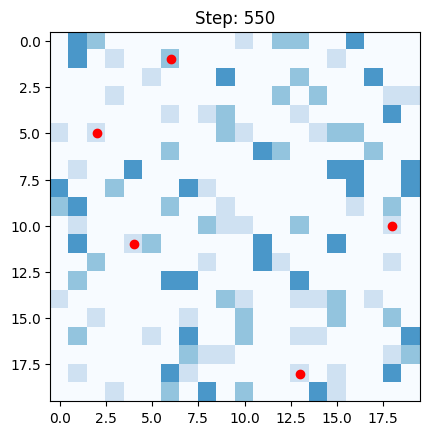

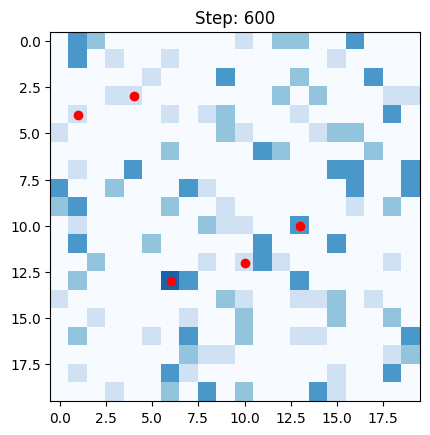

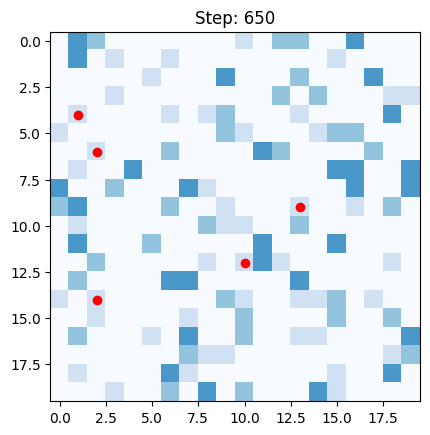

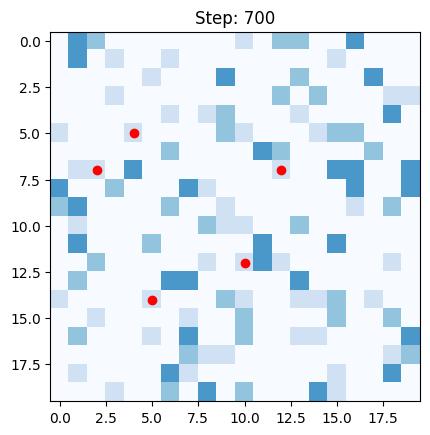

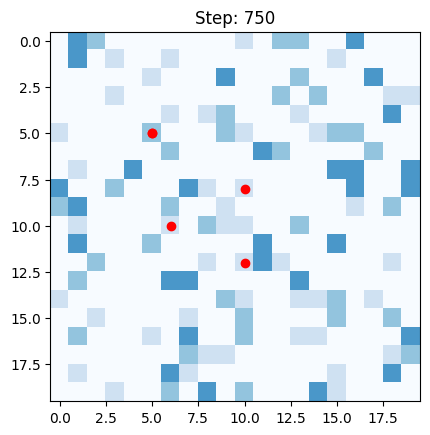

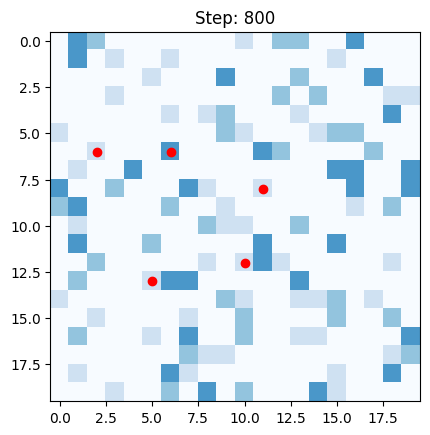

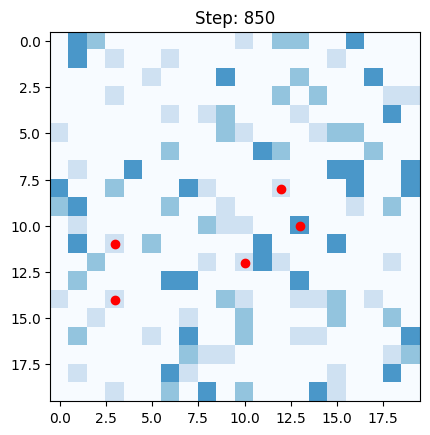

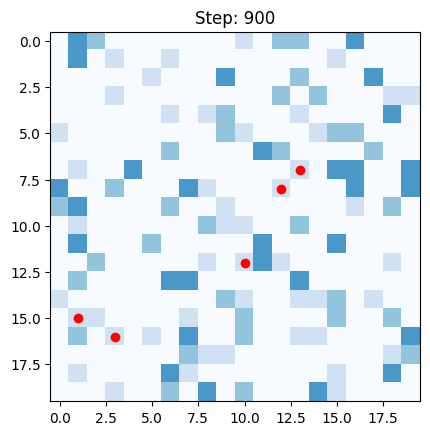

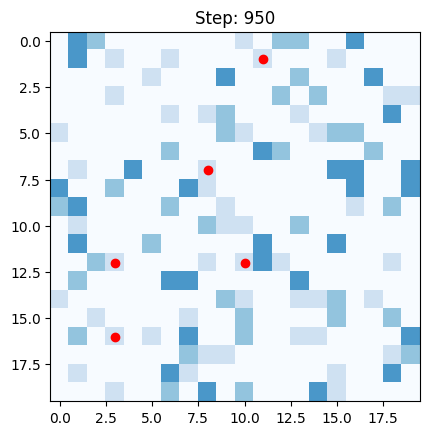

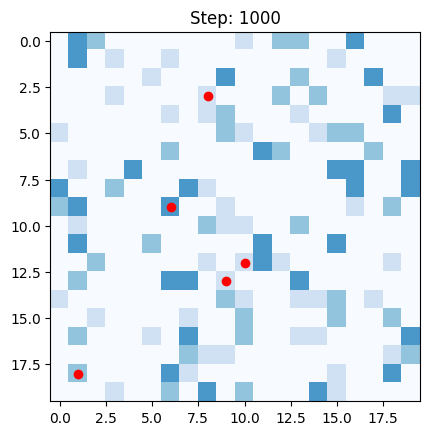

Simulation completed in 1000 steps.


In [8]:
def run_simulation(warehouse, robots, max_steps=1000):
    steps = 0
    while not all_stacks_correct(warehouse) and steps < max_steps:
        new_positions = []
        for robot in robots:
            new_pos = robot_strategy(robot, warehouse)
            new_positions.append(new_pos)
            if pick_up_box(robot, warehouse):
                drop_box(new_pos, warehouse)
        robots = new_positions
        steps += 1
        if steps % 50 == 0:
            visualize_warehouse(warehouse, robots, steps)
    return steps

def all_stacks_correct(warehouse):
    return np.all((warehouse == 0) | (warehouse == TARGET_STACK_HEIGHT))

def visualize_warehouse(warehouse, robots, step):
    plt.imshow(warehouse, cmap='Blues', vmin=0, vmax=TARGET_STACK_HEIGHT)
    for robot in robots:
        plt.scatter(robot[1], robot[0], c='red')
    plt.title(f'Step: {step}')
    plt.show()

steps = run_simulation(warehouse, robots)
print(f'Simulation completed in {steps} steps.')


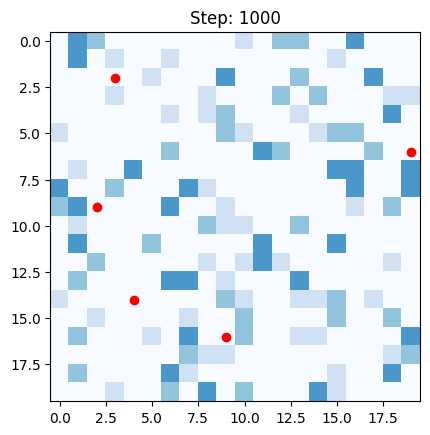

In [9]:
visualize_warehouse(warehouse, robots, steps)


Estado inicial del almacén:
[[0 3 2 0 0 0 0 0 0 0 1 0 2 2 0 0 3 0 0 0]
 [0 3 0 2 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 3 0 0 0 2 0 0 0 3 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 2 0 2 0 0 0 1 1]
 [0 0 0 0 0 0 1 0 1 2 0 0 0 1 0 0 0 0 3 0]
 [1 0 0 0 0 0 0 0 0 2 1 0 0 0 1 2 2 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 3 2 0 0 0 0 3 0 0]
 [0 1 0 0 3 0 0 0 0 0 0 0 0 0 0 3 3 0 0 3]
 [3 0 0 3 0 0 0 3 1 0 0 0 0 0 0 0 3 0 0 3]
 [2 3 0 0 0 0 2 0 0 1 0 0 0 0 0 0 1 0 2 0]
 [0 1 0 0 0 0 0 0 2 1 1 0 0 2 0 0 0 0 0 0]
 [0 3 0 0 0 2 0 0 0 0 0 3 0 0 0 3 0 0 0 0]
 [0 0 2 0 0 0 0 0 1 0 0 3 1 0 0 0 0 0 1 0]
 [0 2 0 0 0 0 3 3 0 0 0 0 0 3 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 2 1 0 0 1 1 2 0 1 0 0]
 [0 0 1 0 0 0 0 1 0 0 2 0 0 0 0 2 0 0 2 0]
 [0 2 0 0 0 1 0 3 0 0 3 0 0 1 1 0 0 0 0 3]
 [0 0 0 0 0 0 0 2 1 1 0 0 0 0 0 0 0 0 1 2]
 [0 2 0 0 0 0 3 1 0 0 0 0 0 0 0 1 0 0 3 0]
 [0 0 0 1 0 0 2 0 3 0 2 0 0 0 3 1 0 0 0 0]]
Posiciones iniciales de los robots:
[(9, 2), (6, 19), (2, 3), (14, 4), (16, 9)]


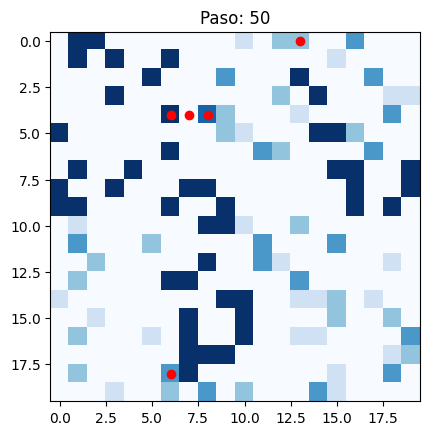

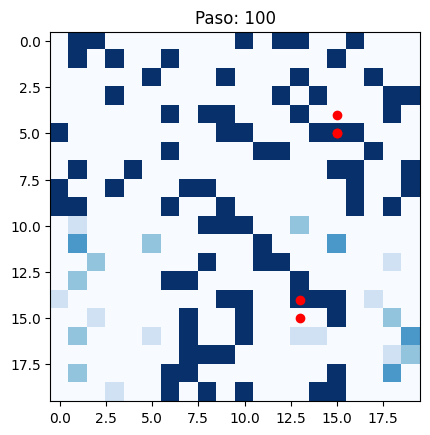

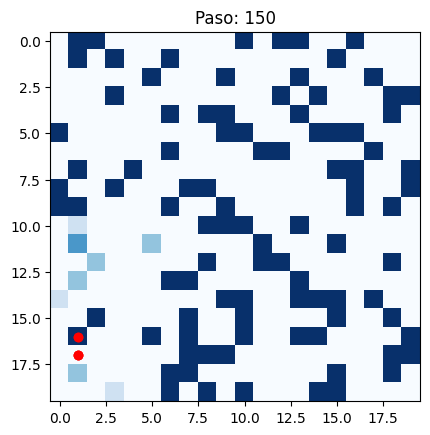

Simulación completada en 184 pasos.


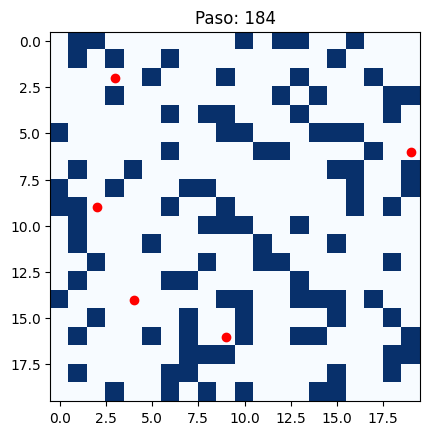

Estado final del almacén:
[[0 5 5 0 0 0 0 0 0 0 5 0 5 5 0 0 5 0 0 0]
 [0 5 0 5 0 0 5 0 0 0 0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 5 0 0 0 5 0 0 0 5 0 0]
 [0 0 0 5 0 0 0 0 0 0 0 0 5 0 5 0 0 0 5 5]
 [0 0 0 0 0 0 5 0 5 5 0 0 0 5 0 0 0 0 5 0]
 [5 0 0 0 0 0 0 0 0 5 5 0 0 0 5 5 5 0 0 0]
 [0 0 0 0 0 0 5 0 0 0 0 5 5 0 0 0 0 5 0 0]
 [0 5 0 0 5 0 0 0 0 0 0 0 0 0 0 5 5 0 0 5]
 [5 0 0 5 0 0 0 5 5 0 0 0 0 0 0 0 5 0 0 5]
 [5 5 0 0 0 0 5 0 0 5 0 0 0 0 0 0 5 0 5 0]
 [0 5 0 0 0 0 0 0 5 5 5 0 0 5 0 0 0 0 0 0]
 [0 5 0 0 0 5 0 0 0 0 0 5 0 0 0 5 0 0 0 0]
 [0 0 5 0 0 0 0 0 5 0 0 5 5 0 0 0 0 0 5 0]
 [0 5 0 0 0 0 5 5 0 0 0 0 0 5 0 0 0 0 0 0]
 [5 0 0 0 0 0 0 0 0 5 5 0 0 5 5 5 0 5 0 0]
 [0 0 5 0 0 0 0 5 0 0 5 0 0 0 0 5 0 0 5 0]
 [0 5 0 0 0 5 0 5 0 0 5 0 0 5 5 0 0 0 0 5]
 [0 0 0 0 0 0 0 5 5 5 0 0 0 0 0 0 0 0 5 5]
 [0 5 0 0 0 0 5 5 0 0 0 0 0 0 0 5 0 0 5 0]
 [0 0 0 5 0 0 5 0 5 0 5 0 0 0 5 5 0 0 0 0]]
Todas las cajas están apiladas en 5 pilas.


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Semilla para la generación de números aleatorios
random.seed(67890)
np.random.seed(67890)

# Constantes
WAREHOUSE_SIZE = 20
NUM_BOXES = 200
NUM_ROBOTS = 5
MAX_BOX_STACK = 3
TARGET_STACK_HEIGHT = 5

# Inicialización del almacén (0: vacío, -1: pared, 1-5: número de cajas en la pila)
warehouse = np.zeros((WAREHOUSE_SIZE, WAREHOUSE_SIZE), dtype=int)

def place_initial_boxes(warehouse, num_boxes, max_box_stack):
    remaining_boxes = num_boxes
    while remaining_boxes > 0:
        stack_height = min(random.randint(1, max_box_stack), remaining_boxes)
        x, y = random.randint(0, WAREHOUSE_SIZE-1), random.randint(0, WAREHOUSE_SIZE-1)
        if warehouse[x, y] == 0:
            warehouse[x, y] = stack_height
            remaining_boxes -= stack_height

place_initial_boxes(warehouse, NUM_BOXES, MAX_BOX_STACK)
print("Estado inicial del almacén:")
print(warehouse)

robots = []

def place_robots(warehouse, num_robots):
    while len(robots) < num_robots:
        x, y = random.randint(0, WAREHOUSE_SIZE-1), random.randint(0, WAREHOUSE_SIZE-1)
        if warehouse[x, y] == 0 and (x, y) not in robots:
            robots.append((x, y))

place_robots(warehouse, NUM_ROBOTS)
print("Posiciones iniciales de los robots:")
print(robots)

def move_robot(robot, direction):
    x, y = robot
    if direction == 'up' and x > 0:
        x -= 1
    elif direction == 'down' and x < WAREHOUSE_SIZE - 1:
        x += 1
    elif direction == 'left' and y > 0:
        y -= 1
    elif direction == 'right' and y < WAREHOUSE_SIZE - 1:
        y += 1
    return (x, y)

def get_adjacent_cells(robot):
    x, y = robot
    cells = {
        'up': (x-1, y) if x > 0 else None,
        'down': (x+1, y) if x < WAREHOUSE_SIZE - 1 else None,
        'left': (x, y-1) if y > 0 else None,
        'right': (x, y+1) if y < WAREHOUSE_SIZE - 1 else None
    }
    return cells

def sense_environment(robot, warehouse):
    cells = get_adjacent_cells(robot)
    sensed = {}
    for direction, cell in cells.items():
        if cell is None:
            sensed[direction] = 'wall'
        else:
            x, y = cell
            if warehouse[x, y] == -1:
                sensed[direction] = 'wall'
            elif warehouse[x, y] == 0:
                sensed[direction] = 'empty'
            elif 1 <= warehouse[x, y] <= 5:
                sensed[direction] = f'boxes_{warehouse[x, y]}'
            elif cell in robots:
                sensed[direction] = 'robot'
    return sensed

def pick_up_box(robot, warehouse):
    x, y = robot
    if warehouse[x, y] > 0:
        warehouse[x, y] -= 1
        return True
    return False

def drop_box(robot, warehouse):
    x, y = robot
    if warehouse[x, y] < TARGET_STACK_HEIGHT:
        warehouse[x, y] += 1
        return True
    return False

def find_nearest_box(robot, warehouse):
    x, y = robot
    min_distance = float('inf')
    target = None
    for i in range(WAREHOUSE_SIZE):
        for j in range(WAREHOUSE_SIZE):
            if 1 <= warehouse[i, j] < TARGET_STACK_HEIGHT:
                distance = abs(x - i) + abs(y - j)
                if distance < min_distance:
                    min_distance = distance
                    target = (i, j)
    return target

def robot_strategy(robot, warehouse, carrying_box):
    if carrying_box:
        # Avanza hacia una pila que pueda aceptar más cajas (<5).
        target = find_nearest_box(robot, warehouse)
        if target:
            target_x, target_y = target
            if robot == target:
                return robot, drop_box(robot, warehouse)
            if robot[0] < target_x:
                return move_robot(robot, 'down'), carrying_box
            elif robot[0] > target_x:
                return move_robot(robot, 'up'), carrying_box
            elif robot[1] < target_y:
                return move_robot(robot, 'right'), carrying_box
            elif robot[1] > target_y:
                return move_robot(robot, 'left'), carrying_box
    else:
        # Avanza hacia una caja para recoger
        target = find_nearest_box(robot, warehouse)
        if target:
            target_x, target_y = target
            if robot == target:
                return robot, pick_up_box(robot, warehouse)
            if robot[0] < target_x:
                return move_robot(robot, 'down'), carrying_box
            elif robot[0] > target_x:
                return move_robot(robot, 'up'), carrying_box
            elif robot[1] < target_y:
                return move_robot(robot, 'right'), carrying_box
            elif robot[1] > target_y:
                return move_robot(robot, 'left'), carrying_box
    return robot, carrying_box

def all_stacks_correct(warehouse):
    return np.all((warehouse == 0) | (warehouse == TARGET_STACK_HEIGHT))

def run_simulation(warehouse, robots, max_steps=1000):
    steps = 0
    carrying_boxes = [False] * len(robots)
    while not all_stacks_correct(warehouse):
        new_positions = []
        for i, robot in enumerate(robots):
            new_pos, carrying_box = robot_strategy(robot, warehouse, carrying_boxes[i])
            carrying_boxes[i] = carrying_box
            new_positions.append(new_pos)
        robots = new_positions
        steps += 1
        if steps % 50 == 0:
            visualize_warehouse(warehouse, robots, steps)
    return steps

def visualize_warehouse(warehouse, robots, step):
    plt.imshow(warehouse, cmap='Blues', vmin=0, vmax=TARGET_STACK_HEIGHT)
    for robot in robots:
        plt.scatter(robot[1], robot[0], c='red')
    plt.title(f'Paso: {step}')
    plt.show()

steps = run_simulation(warehouse, robots)
print(f'Simulación completada en {steps} pasos.')
visualize_warehouse(warehouse, robots, steps)
print("Estado final del almacén:")
print(warehouse)

# Verificación final de las pilas
if all_stacks_correct(warehouse):
    print("Todas las cajas están apiladas en 5 pilas.")
else:
    print("Algunas cajas no están correctamente apiladas.")
